In [1]:
import os
import numpy as np
from flax import nnx
import orbax.checkpoint as ocp

from net import CNN
from feeder import loader

In [2]:
model = nnx.eval_shape(lambda: CNN(rngs=nnx.Rngs(0)))
graphdef, state = nnx.split(model)

with ocp.CheckpointManager(
    os.path.join(os.getcwd(), 'checkpoints/'),
    options = ocp.CheckpointManagerOptions(max_to_keep=1),
    ) as mngr:
    state = mngr.restore(4000, args=ocp.args.StandardRestore())
    model = nnx.merge(graphdef, state)

In [3]:
latents = []
labels = []

val_loader = loader(dataset_path='data/mnist.npz', data='x_val', label='y_val', batch_size=1024, num_epoch=1)
for batch in val_loader:
    labels.append(batch['label'])
    batch_latent, batch_logit = model(batch['data'])
    latents.append(batch_latent)

labels = np.concatenate(labels, axis=0)
latents = np.concatenate(latents, axis=0)

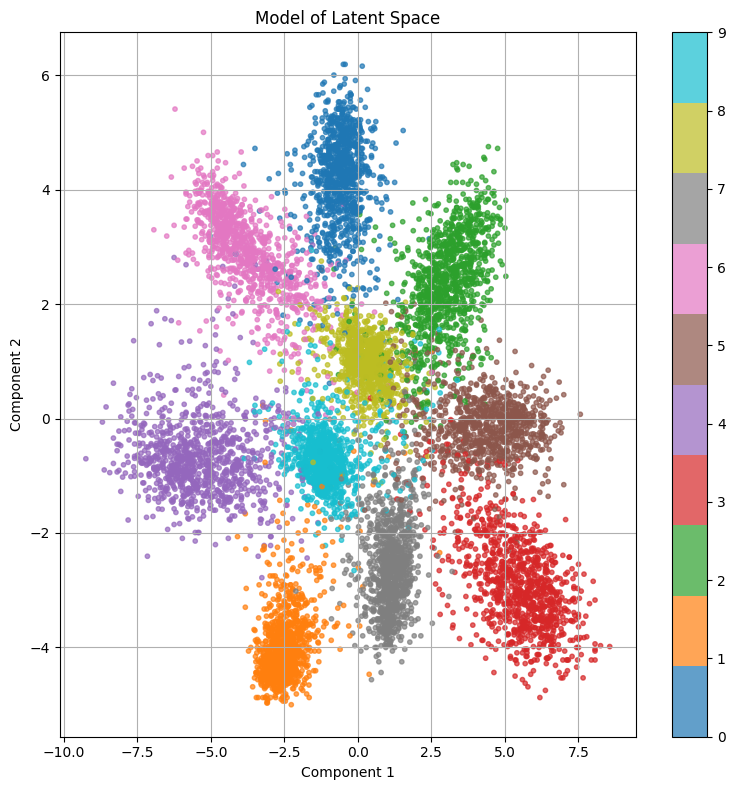

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', s=10, alpha=0.7)
plt.colorbar(scatter, ticks=range(10))
plt.title('Model of Latent Space')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()